In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

# Load the MNIST fashion dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0


X_val = X_train[:10000]
y_val = y_train[:10000]

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [23]:
X_train.shape

(60000, 28, 28)

In [10]:
#LeNet architecture implementation
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.AveragePooling2D(),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation='relu'),
    tf.keras.layers.AveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(84, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])


model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [13]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[es] )

# Evaluate the model on the test set


Epoch 1/50
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2160 - accuracy: 0.9187 - val_loss: 0.2087 - val_accuracy: 0.9247
Epoch 2/50
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2060 - accuracy: 0.9219 - val_loss: 0.1880 - val_accuracy: 0.9292
Epoch 3/50
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1981 - accuracy: 0.9237 - val_loss: 0.1817 - val_accuracy: 0.9341
Epoch 4/50
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1943 - accuracy: 0.9267 - val_loss: 0.1679 - val_accuracy: 0.9343
Epoch 5/50
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1832 - accuracy: 0.9299 - val_loss: 0.1518 - val_accuracy: 0.9402
Epoch 6/50
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1841 - accuracy: 0.9300 - val_loss: 0.1587 - val_accuracy: 0.9390
Epoch 7/50
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1734 - accuracy: 0.9338 - val_loss: 0.1320 - val_accuracy:

In [16]:

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")

313/313 [==============================] - 1s 3ms/step - loss: 0.6954 - accuracy: 0.8766
Test accuracy: 0.8766000270843506


In [28]:
from tensorflow.keras.applications import EfficientNetB0

X_train224 = tf.image.grayscale_to_rgb(tf.expand_dims(X_train, axis=-1)).numpy()
X_test224 = tf.image.grayscale_to_rgb(tf.expand_dims(X_test, axis=-1)).numpy()
X_val224 = tf.image.grayscale_to_rgb(tf.expand_dims(X_val, axis=-1)).numpy()

IMG_SIZE = 224
X_train224 = tf.image.resize(X_train224, (IMG_SIZE, IMG_SIZE)).numpy()
X_test224 = tf.image.resize(X_test224, (IMG_SIZE, IMG_SIZE)).numpy()
X_val224 = tf.image.resize(X_val224, (IMG_SIZE, IMG_SIZE)).numpy()

num_classes = 10
y_train224 = tf.keras.utils.to_categorical(y_train, num_classes)
y_tes224 = tf.keras.utils.to_categorical(y_test, num_classes)
y_val224 = tf.keras.utils.to_categorical(y_val, num_classes)

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # Freeze the base model

# Add custom classification head
x = base_model.output
x = tf.keras.layer.GlobalAveragePooling2D()(x)
x = tf.keras.layer.Dense(128, activation='relu')(x)
predictions = tf.keras.layer.Dense(num_classes, activation='softmax')(x)

model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


ValueError: 'images' must have either 3 or 4 dimensions.

In [ ]:

# Train the model
model.fit(X_train224, y_train224, epochs=10, batch_size=32, validation_data=(X_val224, y_val224), callbacks=[es])

# Evaluate the model
loss, accuracy = model.evaluate(X_test224, y_test224, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

In [22]:
history = en.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[es] )

Epoch 1/50


ValueError: in user code:

    File "c:\Users\yardz\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\yardz\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\yardz\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\yardz\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\yardz\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\yardz\anaconda3\envs\tf\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "efficientnetb0" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(32, 28, 28)


In [ ]:
test_loss, test_accuracy = en.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")

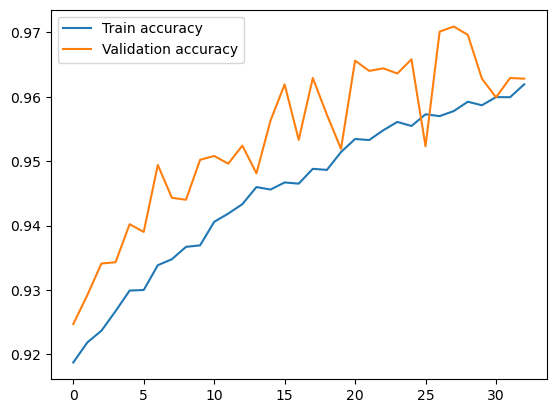

In [15]:
from matplotlib import pyplot as plt

# Plot the training and validation accuracy

plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.show()

error: incomplete escape \U at position 28